In [1]:
import sys
sys.path.append('../../')

In [2]:
from scripts.utils import set_mpl, read_london
set_mpl()
%matplotlib widget


matplotlib settings set
matplotlib settings set


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Prepare data

In [4]:
london_std, london_tou, london_weather, london_twitter = read_london()


london_std = london_std.query('index>"2012-01-01"')
london_weather = london_weather.query('index>"2012-01-01"')
london_twitter = london_twitter.query('index>"2012-01-01"')


    Loading London data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Weather from `meteostat` package.

    STD and ToU tariffs are separated.
    Data resampled (mean) to 1H resolution from original 30min resolution.

    reutrns:
    df_std: pd.DataFrame with STD tariff data
    df_tou: pd.DataFrame with ToU tariff data
    df_weather: pd.DataFrame with weather data
    df_twitter: pd.DataFrame with twitter data (see `0_data/2.2_london_twitter.ipynb` for details)
    
    


In [5]:
missed_frac = london_std.isna().mean(axis = 0).sort_values(ascending = False)
#drop columns with more than xx% missing values
data = london_std.drop(missed_frac[missed_frac > 0.3].index, axis = 1)
homes_col = data.columns
cols = data.columns


#select homes with mean energy consumption close to  0.1
data_cluster = data[cols[ (data[cols].mean() > 0.1) & (data[cols].mean() < 0.15) ]]
data_cluster = data_cluster.T.sample(300).T
print(f"number of homes: {data_cluster.shape[1]}")
power_avg = data_cluster.mean(axis=1).to_frame()
power_avg.columns = ['power_avg']



number of homes: 300


In [6]:
#time series modelling with random forest and covariates
from darts import TimeSeries
from darts.metrics import mape, smape
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr


target_orig = TimeSeries.from_dataframe(power_avg, freq = 'H')

hodidays_covariates = target_orig.add_holidays("UK")['holidays']


temperature_history = london_weather['temp']/np.max(london_weather['temp'])
#perturb temperature to avoid perfect correlation
rolling_std = temperature_history.rolling(24*3).std()
temperature_forecast = temperature_history + np.random.normal(0, rolling_std, size = len(temperature_history))

#temperature_covariate_past = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
#temperature_covariate_future  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
temperature_covariate  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H') #we can use it as past and future, although it is not perfect for past predictions

#twitter_covariate = TimeSeries.from_dataframe(london_twitter[['tweets_total']], freq = 'H')
twitter_covariate = TimeSeries.from_dataframe(london_twitter, freq = 'H')

#datetime encodings (normalized)
datetime_covatiates = concatenate(
    [
        dt_attr(time_index = target_orig, attribute =  "hour", one_hot = False, cyclic = False )/24,
        dt_attr(time_index = target_orig, attribute =  "day_of_week", one_hot = False, cyclic = False )/7,
        dt_attr(time_index = target_orig, attribute =  "month", one_hot = False, cyclic = False )/12,
        dt_attr(time_index = target_orig, attribute =  "day_of_year", one_hot = False, cyclic = False )/365,
    ],
    axis="component",
)

# Model

In [23]:
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, mape, mase
from sklearn.preprocessing import MaxAbsScaler
from darts.models import XGBModel, LinearRegressionModel


def predict_london(timestamp = '2013-03-07', horizon = 24*7):

        train, test = target_orig.split_before(pd.Timestamp(timestamp))
        test = test.head(horizon*2)

        scaler = Scaler(scaler=MaxAbsScaler())
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
        target = scaler.transform(target_orig)



        lags_horizon = list(np.hstack([np.arange(1, 25), [168]]))
        lags_horizon = [int(x) for x in lags_horizon]
        lags_horizon_past = [-int(x) for x in lags_horizon]
        lags_horizon_past.sort()
        lags_horizon_future = lags_horizon + lags_horizon_past



        model_naive = LinearRegressionModel(lags_past_covariates=[-168])
        model_naive.fit(train, past_covariates = target)
        model_naive.model.coef_ = np.array([[1.0]])
        model_naive.model.intercept_=0.0




        cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates],
                "past_covariates": [twitter_covariate],}

        xgb_args = {'learning_rate' : 0.065, 'n_estimators': 350, 'max_depth': 3, 'verbosity': 0, 'n_jobs': 4}
        model = XGBModel(lags_future_covariates = lags_horizon_future , lags_past_covariates=lags_horizon_past,
                                **xgb_args  )                                
        model.fit(train, **cov_args)


        output_dict = {'naive': {'model': model_naive},
                'xgb': {'model': model},
                }




        for model_name, model_params in output_dict.items():
                model = model_params['model']
                pred_test = model.predict(horizon, train)
                pred_train = model.predict(horizon, train.head(-horizon), )

                output_dict[model_name]['pred_test'] = pred_test
                output_dict[model_name]['pred_train'] = pred_train

                smape_train = smape(pred_train, train.tail(horizon))
                smape_test = smape(pred_test, test.head(horizon))

                output_dict[model_name]['smape_train'] = smape_train
                output_dict[model_name]['smape_test'] = smape_test

        pred_test_ensemble = (output_dict['naive']['pred_test']+output_dict['xgb']['pred_test'])/2
        smape_test_ensemble = smape(pred_test_ensemble, test.head(horizon))

        pred_train_ensemble = (output_dict['naive']['pred_train']+output_dict['xgb']['pred_train'])/2
        smape_train_ensemble = smape(pred_train_ensemble, train.tail(horizon))

        output_dict['ensemble'] = {'pred_test': pred_test_ensemble, 'pred_train': pred_train_ensemble,
                'smape_train': smape_train_ensemble, 'smape_test': smape_test_ensemble, 'label': 'ensemble'}    

        output_dict['train'] = train.tail(horizon*2)
        output_dict['test'] = test


        return output_dict




In [46]:
results = predict_london('2013-05-25')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


7.135986471890194
6.052600033232679
6.066166555355863


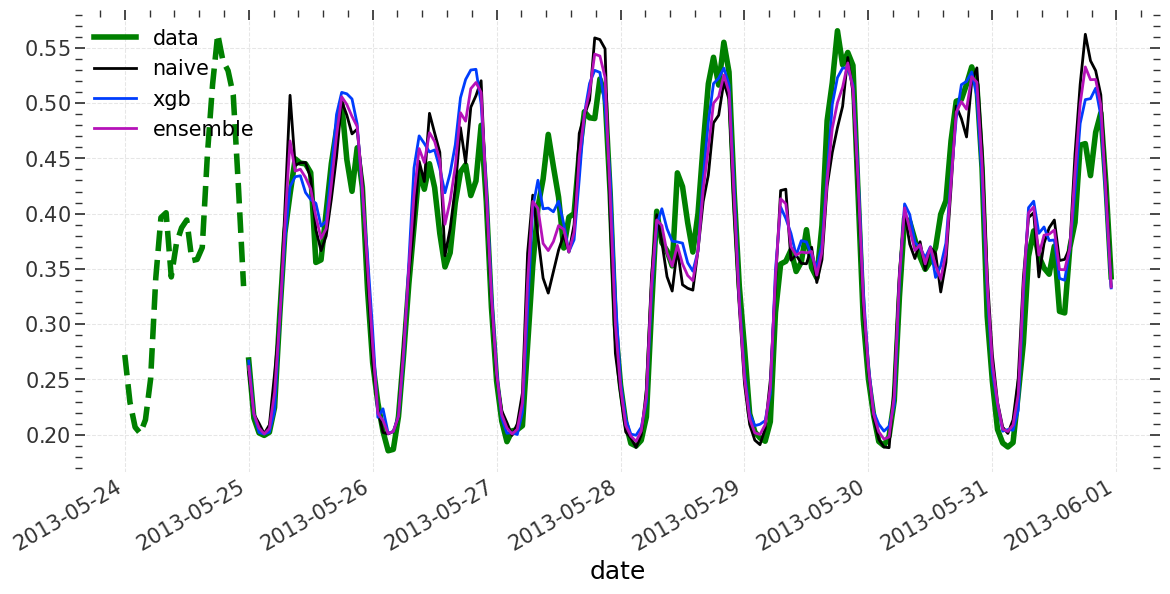

In [47]:
%matplotlib inline
fig,  ax =  plt.subplots( figsize = (14,6))

results['train'].tail(24).plot(ax = ax, label = '_', lw = 4, alpha =0.1, color = 'green', ls = '--')
results['test'].head(168).plot(ax = ax, label = 'data', lw = 4, alpha =0.1, color = 'green')


for model_name in ['naive', 'xgb', 'ensemble']:
    results[model_name]['pred_test'].plot(ax = ax, label = model_name, lw = 2, alpha =0.4)


print(results['naive']['smape_test'])
print(results['xgb']['smape_test'])
print(results['ensemble']['smape_test'])


In [ ]:
results = predict_london()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


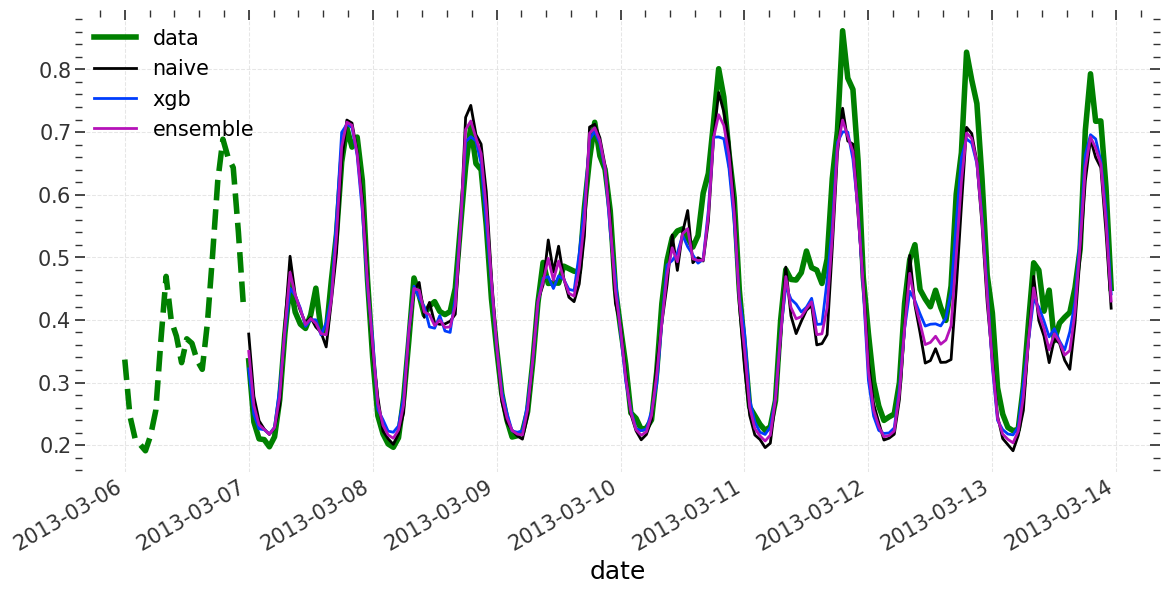

In [44]:
%matplotlib inline
fig,  ax =  plt.subplots( figsize = (14,6))

results['train'].tail(24).plot(ax = ax, label = '_', lw = 4, alpha =0.1, color = 'green', ls = '--')
results['test'].head(168).plot(ax = ax, label = 'data', lw = 4, alpha =0.1, color = 'green')


for model_name in ['naive', 'xgb', 'ensemble']:
    results[model_name]['pred_test'].plot(ax = ax, label = model_name, lw = 2, alpha =0.4)


print(results['naive']['smape_test'])
print(results['xgb']['smape_test'])
print(results['ensemble']['smape_test'])
